# ME233 Final Project  
## Santa Clara County Data


Import the necessary packages.

In [1]:
import numpy as np
import os
import scipy.io

from scipy.integrate import odeint
import matplotlib.pyplot as plt
current = os.getcwd()
import pandas as pd
import datetime
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
filename = os.path.basename(current)[:-3]

import matplotlib.gridspec as gridspec

### Load data for Santa Clara County

In [2]:
#%% Load covid19 data from NY times

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')


def getData_US(df_covid19us,ctr,End_time,Start_time,window):
   
    dates = df_covid19us.date
    Time_series = pd.to_datetime( df_covid19us['date'] )
    filtered_df = df_covid19us[(Time_series >= Start_time) & (Time_series <= End_time)] 
    df_state = filtered_df.loc[filtered_df.county == ctr]
    Cases = df_state['cases'].to_numpy()
    NewCases = np.diff(Cases)
    NewCases_smooth = movingaverage(NewCases,window)
    
    return Cases, NewCases, NewCases_smooth


def getData_Own(Cases,window):
   
    NewCases = np.diff(Cases)
    NewCases_smooth = movingaverage(NewCases,window)
    
    return Cases, NewCases, NewCases_smooth

#online data
def LoadData():
    url='https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv'
    df_covid19us = pd.read_csv(url).sort_values(['county','date'])     #, index_col=['data', 'county', 'state', 'fips', 'cases','deaths']
    
    #Save copy
    today = datetime.datetime.now()
    if today.hour < 12:
        h = "00"
    else:
        h = "12"
    path2save = "data_backup/SaveCopies/" + today.strftime('%Y%m%d')+ h
    Today_str = today.strftime('%Y%m%d')+ h
    if not os.path.exists(path2save):
        os.makedirs(path2save)
    
    df_covid19us.to_csv(path2save+'/ConfirmedCases.csv')
    
    return df_covid19us

#load stored data
def LoadStoredData(Timestr):

    path2load = "data_backup/SaveCopies/" + Timestr
    df_covid19us = pd.read_csv(path2load)
    
    return df_covid19us

In this cell, you decide which US state or country you want to examine and during which time frame. Choose `ctr`, `Population_total`, `Tmax` and `Start_time` accordingly.

We recommend choosing the same `Start_time` as in the last homework. This time, choose `Tmax` large enough so that you see a flattening and decline of the smoothed curve of new cases when you plot the raw data.



In [3]:

# Choose US State/country/city
ctr ='Santa Clara'
# Location's population
Population_total = 1928000
# Choose time period to consider
Tmax = 30
# Choose start date
Start_time = pd.to_datetime( datetime.date(2020,10,15))
# Time window for data smoothing 
window = 7
# Resulting last considered time point
End_time = Start_time + pd.Timedelta(pd.offsets.Day(Tmax -1 ))
# Dates array
time_full = pd.date_range(start=Start_time, end=End_time)


##### Get data ######
df_covid19us = LoadData()
# Extract Case numbers, daily new case numbers and smoothed daily new case number by applying a moving avarage
Cases, NewCases, NewCases_smooth  = getData_US(df_covid19us, ctr, End_time, Start_time, window)


### Plot raw data 
Here, we want you to plot the daily new cases over time. The plot will show both the raw and the smoothed data. 
Since the smoothed data is calculated through a moving average over a window of 7 days, it doesn't make sense to plot it for the last 7 days of the observation period.

Text(0, 0.5, 'Reported cases')

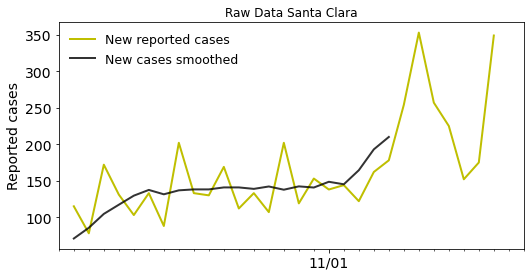

In [4]:
# Plooting raw data
fig, ax1 = plt.subplots(figsize=(600/72,300/72))


ax1.plot(time_full[:-1], NewCases, color = 'y', lw=2,zorder=1, alpha=1.0, label=r'New reported cases')  
ax1.plot(time_full[:-(1+window)], NewCases_smooth[:-window], color = 'black',lw=2,zorder=3, alpha=0.8, label=r'New cases smoothed') # 


leg = plt.legend(loc='upper left',ncol=1,frameon=True,fontsize=12.5)
leg.get_frame().set_linewidth(0.0)

ax1.set_title('Raw Data '+ctr) 
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.xaxis.set_minor_locator(mdates.DayLocator())
ax1.xaxis.set_minor_locator(mdates.DayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax1.set_xlim([Start_time-pd.Timedelta(days=1), Start_time + pd.Timedelta(pd.offsets.Day(Tmax))]) 
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)
plt.ylabel('Reported cases',fontsize=14)


### Explicit SEIR model

In [5]:
#%% #####################  SEIR model #########################################


def SEIR_explicit(Sarr, Earr, Iarr, Rarr, isteps, fa, fb, fc, Population):
    
    Sout= np.empty((isteps))
    Eout= np.empty((isteps))
    Iout= np.empty((isteps))
    Rout= np.empty((isteps))
        
    Inew_out= np.empty((isteps))
        
    for s in range(0,isteps):

        new_Et = (fb * Sarr * Iarr)* dt 
        new_It =  (fa*Earr )* dt 
        new_Rt =  (fc * Iarr)* dt 

        
        SarrNew = Sarr - new_Et
        EarrNew = Earr + new_Et - new_It
        IarrNew = Iarr + new_It - new_Rt
        RarrNew = Rarr + new_Rt
    
    
        Sarr, Earr, Iarr, Rarr = SarrNew, EarrNew, IarrNew, RarrNew
    
        Sout[s] = Sarr
        Eout[s] = Earr
        Iout[s] = Iarr
        Rout[s] = Rarr
        Inew_out[s] = new_It
        
    confirmed = Population * (Iout  + Rout)
  
    return confirmed, Population *Sout, Population *Eout, Population *Iout, Population *Rout, Population *Inew_out
    
    

### Define fitting function

Here we define the necessary functions to fit the model parameters `fb`, `fa`, `fc`, `rho`, `N` to the observed data.

In [6]:
#%% Fitting function

from lmfit import minimize, Parameters

class SEIR_Fit:

    def __init__(self):
        pass

    def residual(self,params, x, data):

        fb = params['beta']
        fa = params['alpha']
        fc = params['gamma']
        rho = params['rho']
        N = params['N']
        
        R_0 = 0.0
        E_0 = data[0]/N * rho
        I_0 = data[0]/N
        S_0 = 1.0 - E_0 - I_0 - R_0

        confirmed, S, E, I, R, Inew = SEIR_explicit(S_0, E_0, I_0, R_0, isteps, fa, fb,fc, 1.0)
        INew_out = Inew.reshape(-1,skip, order='C').sum(axis=1)

        residual = INew_out - (data /N)

        return residual

    def fit(self,t, data,params=None, method='nelder'):

        if params is None:
            params = Parameters()
            beta = 0.6 #beta = beta_0*k - beta = the coefficient of infection rate, beta_0 = the probability of infection per exposure, k=the frequency of exposure
            alpha = 1/2.5   #alpha = 1/T_e - T_e = the average latency
            gamma = 1/6.5 #gamma = 1/ T_i - T_i = the average infection time
            Nmin=1
            Nmax=Population_total
            N = 11
            
            params.add('beta',value=beta, min=0.00, vary=True)
            params.add('alpha',value=alpha, min=0.01, vary=False)
            params.add('gamma',value=gamma, min=0.01, vary=False) 
            params.add('rho',value=1,min=0., max=50, vary=True)
            params.add('N',value=N, min=Nmin, max=Nmax, vary=True)

        out = minimize(self.residual, params, args=(t, data, ),
                       method=method,
                )
        return out


### Time integration settings

In [7]:
#%% ################### Time integration settings ##############################################
trainmodel = True
filename = os.path.basename(current)[:-3]

dt      = 0.1            # Time increment     
isteps =int((Tmax-window-1)/dt) 

# Time array to be fitted
days_size = Tmax-window-1
days = np.arange(0,days_size, 1)
skip = int(1/dt)

### Model fitting

In [8]:
#%% ############### Model fitting and obtaining fitted parameters ###########################
model = SEIR_Fit()
out = model.fit(days,NewCases_smooth[:-window])
params = out.params


# Call fitted parameters
rho = params['rho'].value
N  = params['N'].value
fc = params['gamma'].value
fb = params['beta'].value
fa = params['alpha'].value

# Initialize intial conditions for model plotting
E_0 = NewCases_smooth[0]/N * rho
I_0 = NewCases_smooth[0]/N
R_0 = 0
S_0 = 1.0 - E_0 - I_0 - R_0

# Call the SEIR model again with the fitted parameters
confirmed, S, E, I, R, Inew = SEIR_explicit(S_0,E_0,
                                                I_0,
                                                R_0, isteps,
                                                fa,
                                                fb,
                                                fc,
                                                N)

INew_out = Inew.reshape(-1,skip, order='C').sum(axis=1)




# Compute R0 and eta based from fitting results
R0 = fb/fc
eta = N/Population_total

print('eta=',eta)


eta= 0.9999999927899285


### Plot your results

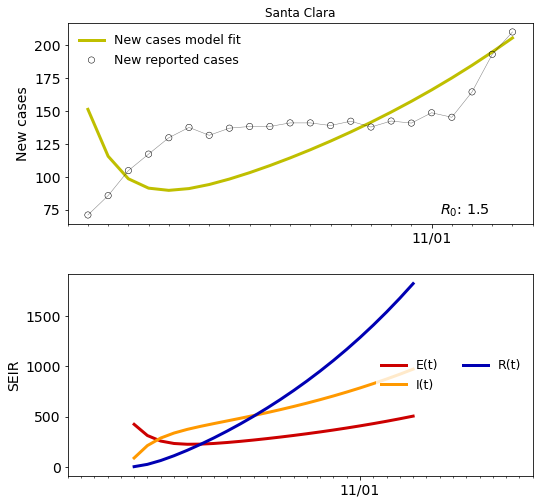

In [9]:
#%% ################### Plot results #######################################
ColorS = [0.5, 0.00, 0.0]
ColorE = [0.8, 0.00, 0.0]
ColorI = [1.0, 0.60, 0.0]
ColorR = [0.0, 0.00, 0.7]

import seaborn as sns
Color_p = sns.color_palette("RdBu", 6)


Tmax_plot = Tmax-window-1
End_time = Start_time + pd.Timedelta(pd.offsets.Day(Tmax_plot -1 ))
time_fit = pd.date_range(start=Start_time, end=End_time)





fig = plt.figure(figsize=(600/72,600/72))
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0.3, hspace=0.25)
ax1 = plt.subplot(gs[0, 0])



ax1.plot(time_fit, INew_out,color = 'y',lw=3,zorder=1, label=r'New cases model fit') # plotting t, b separately 
ax1.plot(time_fit, NewCases_smooth[:-window], color = 'black',lw=0.5,zorder=3, alpha=0.5) # 
ax1.scatter(time_fit, NewCases_smooth[:-window],s=40,lw=0.5, zorder=10, facecolors='none', edgecolors='k', label='New reported cases')


ax1.text(0.8,0.05,r'$R_{0}$: '+f"{R0:.1f}",transform=ax1.transAxes,fontsize='x-large', horizontalalignment='left')


leg = plt.legend(loc='upper left',ncol=1,frameon=True,fontsize=12.5)
leg.get_frame().set_linewidth(0.0)

ax1.set_title('Explicit time integration - confirmed cases') 
ax1.set_title(ctr) 
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.xaxis.set_minor_locator(mdates.DayLocator())
ax1.xaxis.set_minor_locator(mdates.DayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax1.set_xlim([Start_time-pd.Timedelta(days=1), Start_time + pd.Timedelta(pd.offsets.Day(Tmax_plot))]) 
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)
plt.ylabel('New cases',fontsize=14)




# Plotting SEIR Explicit
ax2 = plt.subplot(gs[1, 0])


ax2.plot(time_fit, E[::skip], color = ColorE,lw=3,zorder=1, label=r'E(t)') # 
ax2.plot(time_fit, I[::skip], color = ColorI,lw=3,zorder=1, label=r'I(t)') # 
ax2.plot(time_fit, R[::skip], color = ColorR,lw=3,zorder=1, label=r'R(t)') # 

leg = plt.legend(loc='center right',ncol=2,frameon=True,fontsize=12.5)
leg.get_frame().set_linewidth(0.0)

# ax1.set_ylim(0, 650)

ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2.xaxis.set_minor_locator(mdates.DayLocator())
ax2.xaxis.set_minor_locator(mdates.DayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax2.set_xlim([Start_time-pd.Timedelta(days=5), Start_time + pd.Timedelta(pd.offsets.Day(Tmax))]) 
ax2.xaxis.set_tick_params(labelsize=14)
ax2.yaxis.set_tick_params(labelsize=14)
plt.ylabel('SEIR',fontsize=14)




# Save plotting results
# plt.tight_layout()
path2saveResults = 'Results/'+filename
if not os.path.exists(path2saveResults):
    os.makedirs(path2saveResults)
    
plt.savefig(path2saveResults+'/SEIR_all.pdf') 

## Bayesian Inference

As you have learned in class, Bayesian inference allows us to infer model parameters based on a probabilistic approach. This way we will not obtain single optimal values for our parameters (as we did above), but instead probability distributions which show us the likelihood of different values for each parameter. This also allows us to calculate the uncertainty of our model.

In the plots you just created from the SEIR model using conventional parameter fitting, you should see that the curve of the daily new cases does not align very well with the actual data points. It can not capture the flattening of the data towards the end of the observation time period. Take a moment to think about why that is and which assumptions we would have to change in order to generate a better fit.

In order to show you how to use Bayesian inference and additionally show you how to build a more flexible model, we want to show you three different approaches. For all three approaches we will be inferring the model parameter $\beta$ and thus the reproduction number R. We will keep the other (disease-specific) model parameters $\alpha=1/2.5$ and $\gamma=1/6.5$ fixed. The main difference between the three approaches is the assumption we make about the time-dependency of the reproduction number R(t). 

- (I) In the first approach, we will assume that R0 is constant over time (this is also what we assumed for our conventional parameter fitting). 
- (II) In the second approach, we will assume that R changes over time and will approximate R(t) using a tanh function. 
- (III) In the last approach, we will try to approximate R(t) using a random walk algorithm. 

**Note**: with R(t) we are referring here to the reproduction number, and not to the number of recovered cases!

In order to implement the Bayesian inference, we need to load some more packages. `pymc3` is a package for probabilistic programming and `theano` is a package to work with multi-dimensional arrays.

In [10]:
#%% Bayesian Inference

import pymc3 as pm
import theano

import theano.tensor as tt

In the previous homework we wanted you to find a time increment for numerical integration, that would allow you to use an explicit integration scheme with acceptable accuracy when compared to the exact solution. However, when we add in the complexity of Bayesian inference, the calculations which follow would get extremely costly with such a small time step and would take a long time to compute. For the sake of simplifying and saving computation time, we thus want you to use a time increment of `dt_BI=1` for all calculations below. This will result in small inaccuracies due to the explicit integration scheme, but will be exact enough for the purpose of this homework.

In [11]:
# Note, the the code here isn't prepared to change the dt_BI, in case you want to change it, 
# you have to modify the array size λ and define daily time points in pm.StudentT
dt_BI = 1

### SEIR model in theano
In order to be compatible with theano and pymc3, we need to change the definition of our SEIR model function a little bit. The function `SEIR_BI` takes as an input the array $\lambda$ which contains different values of the model parameter $\beta$ for each time step, the parameters $\mu$ and $\alpha$, the population N and initial conditions for S, E, I and R. Its output are the arrays `S_all`, `E_all`, `I_all`, `R_all` and `new_I_all` containing the predicted values at each time step.

Inside the function `SEIR_BI` we define another function `next_day`, which calculates the updated values for susceptible, exposed, infected and recovered populations at each time increment in the same manner as in our by now well-known explicit integration function `SEIR_explicit`. When you compare the equations to `SEIR_explicit`, you can see that the parameters passed to `SEIR_BI` are equivalent to 
- $\lambda$ = `fb` or $\beta$ (this value is now time-dependent)
- `alpha` = `fa` or $\alpha$
- $\mu$ = `fc` or $\gamma$

After defining `next_day` we call the `theano.scan` functionality. This function is the theano equivalent to a for-loop, which we used so far to loop over the time increments. Look up the description of this scan function here: http://deeplearning.net/software/theano/library/scan.html (scroll all the way down to reference - theano.scan for an overview). Briefly, `theano.scan` iterates a function `fn` over the elements of an array `sequences`. The initial values for the outputs are given in `outputs_info`. 

In our case, we want to scan the function `next_day` along the array containing the different values for $\beta$ at each time increment. As initial conditions, we need to provide the initial values for S, E, R and I as they are given to the function `SEIR_BI`, as well as `new_I_0` which initializes an array to keep track of the daily new cases. Please complete the function call for `theano.scan`!
- Pay attention to the order in which you provide the initial conditions. This has to be the same order, in which S, E, I and R are passed to and returned by the function `next_day`

In [12]:
def SEIR_BI(λ, μ, S_begin, E_begin, R_begin, I_begin, N, alpha, dt):
    
    new_I_0 = tt.zeros_like(I_begin)  #create a new theano tensor object containing only zeros, shaped like `I_begin`
    
    def next_day(λ, S_t_o, E_t_o, R_t_o, I_t_o, _):
        
        new_E_t = (λ / N * I_t_o * S_t_o)*dt
        new_I_t = (alpha* E_t_o)*dt
        new_R_t = (μ * I_t_o )*dt
        
        S_t = S_t_o - new_E_t
        E_t = E_t_o + new_E_t - new_I_t
        I_t = I_t_o + new_I_t - new_R_t
        R_t = R_t_o + new_R_t
        
        return S_t, E_t, R_t, I_t, new_I_t
    
    outputs , _  = theano.scan(fn=next_day, sequences=[λ], 
                               outputs_info=[S_begin, E_begin, R_begin, I_begin, new_I_0])
    
    
    S_all, E_all, R_all, I_all, new_I_all = outputs
    return S_all, E_all, R_all, I_all, new_I_all


### Probabilistic programming with pymc3

For getting to know the pymc3 framework and learning how to use it for Bayesian inference, please read through the introduction and the first example ("A motivating example: linear regression") in this tutorial https://docs.pymc.io/notebooks/getting_started.html 

In the tutorial you learned that for executing Bayesian inference with pymc3 we need to implement several components:

    a) define prior distributions for all of our model parameters
    b) define model prediction based on the model parameters
    c) define likelihood function, which compares the prediction to the observed data taking into account a measurement error
    d) sample from the posterior distribution using Markov Chain Monte Carlo (MCMC) methods

We will now go step by step through the code below, which specifies exactly these components for the three approaches I, II and III. Let's start with the approach where we assume the reproduction number is constant over time. 

#### <span style="color:red">(I) constant R0</span>
- **priors**
    - First, we specify a prior for the observation error `σ_obs`. It is common practice to assume a Half Cauchy distribution with `beta=1` for this error
    - We set the initial recovered cases `R_begin` to zero
    - Since E and I can not be negative, we specify Lognormal priors for their initial conditions. We set the mean value (`mu`) of these distributions to the initial confirmed case numbers and choose a pretty large standard deviation (`sigma`) of 1.0
    - As we did before, we assume all people who are not in infected or exposed groups are susceptible
    - next, we set a normally distributed prior on the reproduction number `R0` that is bound to be larger than 0.01, has a mean of 2.5 and a standard deviation of 1.0
    - We use this definition of R0 to define the prior for our model parameter beta (`beta_arr`) which depends on `R0` and $\gamma$=`fc`. In this first case, we want to keep `R0` and with that `beta_arr` constant over time. Thus, we create an array which contains the same value for each day of the observation period

- **model prediction**
    - To obtain the model predictions based on our model parameters, we call the function `SEIR_BI` which you completed in the cell above. Check above which inputs this function needs and specify the correct inputs by inserting the priors we just defined and the parameters we are keeping fixed 
        - set $\alpha$=`fa`, $\gamma$=`fc` and `N`=`Population_total`
    - the next few lines are used to save the by the model predicted distributions for S,E,I,R and new_I into containers associated with approach (I) (`appr='kst'`)
    
- **likelihood function**
    - Now we define the likelihood function which we want to be evaluated for every sample
    - This function should compare the predicted daily new cases `new_cases` to the observed daily new cases `NewCases_smooth[:-window]`
    - For this purpose, we enter in the studentT distribution the predicted new cases as the mean value (`mu`), define a standard devation based on the measurement error (`sigma`) and enter the observed new cases in `observed`


#### <span style="color:red">(II) tanh approx. of R(t)</span>
- **priors**
    - the priors for measurement error and the initial populations of S,E,I and R are defined in the same way as for appraoch (I)
    - in this approach, we want the time dependent reproduction number R0(t) to be approximated by a tanh function. You learned in class, how a hyperbolic tangent ansatz can be parameterized (or check equation 2 here: https://link.springer.com/content/pdf/10.1007/s00466-020-01880-8.pdf). We need to set priors for the parameters (basic reproduction number: `Rstart`, current reproduction number: `Rt`, adaptation time: `Tan_a`, transition time: `Tan_b`) that define the shape of the function
    - in `R_t = ...` insert the ansatz from the lecture using the specified priors (the current time t is defined in `time_re`)
    - in `λ_t = ...` enter the formula for calculating the model parameter $\beta$ from the reproduction number `R_t` and the parameter `fc`

- **model prediction**
    - calling the model function works in the same way as for approach (I)

- **likelihood function**
    - the likelihood function is defined in the same way as for approach (I)
    
#### <span style="color:red">(III) Random walk approx. of R(t)</span>
A Gaussian random walk, is a random walk algorithm in which the step size varies according to a normal distribution.

- **priors**
    - the new part here are the definitions of the priors for the random walk process
    - we parameterize the random walk using parameters `mu` and `tau`, which are defined as a normal and exponential distribution, respectively
    
    
#### <span style="color:blue">Sampling from the posterior for (I), (II) and (III)</span> 
The sampling from the posterior is handled by pymc3 when we call
`trace = pm.sample(draws=500, tune=500, chains=2, cores=2)` this draws 500 samples from each of the models after drawing 500 intial samples for tuning.

The last line `ppc = pm.sample_posterior_predictive(trace, 1000)` samples from the posterior distribution in order to quantify the uncertainty of the model.


 <span style="color:blue">**Note**</span>: you might see a warning message about a "missing file scan_perform.c" when starting the sampling. Please just ignore this warning. The sampling will still work. The whole process will take around 15 minutes depending on your system and internet connection.

In [13]:

with pm.Model() as model:
    
    
    # -------------------------------------------------------------------------- #
    # SEIR model with constant Reproduction number 
    # -------------------------------------------------------------------------- #
    appr = 'kst'    
    
    # prior of the error of observed cases
    σ_obs = pm.HalfCauchy('σ_obs_{}'.format(appr), beta=1)
    
    R_begin = tt.zeros_like(1, 'float64')
    # priors on the initial conditions
    I_begin = pm.Lognormal('I_begin_{}'.format(appr), mu=np.log(confirmed[0]), sigma=1.0)
    E_begin = pm.Lognormal('E_begin_{}'.format(appr), mu=np.log(confirmed[0]), sigma=1.0)
    S_begin = Population_total - I_begin - E_begin
    
    # prior on the basic reproduction number
    R0 = pm.Bound(pm.Normal, lower=0.01)('R0_{}'.format(appr), mu=2.5, sigma=1.5)
    # Definition of the array of beta(t), here beta is constant over time (beta = R0 * gamma)
    beta_arr = R0*tt.ones(days_size) *fc 
    
    
    
    S_past, E_past, R_past, I_past, new_I_past = SEIR_BI(λ=beta_arr, μ=fc,
                                                         S_begin=S_begin, 
                                                         E_begin=E_begin,
                                                         R_begin=R_begin, 
                                                         I_begin=I_begin,
                                                         N=Population_total,
                                                         alpha=fa,
                                                         dt=dt_BI)
    
     
    new_cases = pm.Deterministic('I_new_{}'.format(appr), new_I_past)
    
    # Saving the SEIR model compartments
    pm.Deterministic('I_past_{}'.format(appr), I_past)
    pm.Deterministic('E_past_{}'.format(appr), E_past)
    pm.Deterministic('R_past_{}'.format(appr), R_past)
    pm.Deterministic('Confirmed_{}'.format(appr), I_past+R_past)

    # Definition of the likelihood function to be solved
    pm.StudentT(
        'obs_{}'.format(appr),
        nu=4,
        mu=new_cases,
        sigma=new_cases ** 0.5 * σ_obs,
        observed=NewCases_smooth[:-window]
        )  

    
    
    # -------------------------------------------------------------------------- #
    # SEIR model with tanh Reproduction
    # -------------------------------------------------------------------------- #
    
    appr = 'tanh'
    σ_obs_tanh = pm.HalfCauchy('σ_obs_{}'.format(appr), beta=1)
    
    R_begin_tanh = tt.zeros_like(1, 'float64')
    I_begin_tanh = pm.Lognormal('I_begin_{}'.format(appr), mu=np.log(confirmed[0]), sigma=1.0)
    E_begin_tanh = pm.Lognormal('E_begin_{}'.format(appr), mu=np.log(confirmed[0]), sigma=1.0) 
    S_begin_tanh = Population_total - I_begin_tanh - E_begin_tanh
    
    # priors for the Rt function
    Rstart = pm.Bound(pm.Normal, lower=0.00)('R0_{}'.format(appr), mu=2.5, sigma=1.5)
    Rt = pm.Bound(pm.Normal, lower=0.00)('Rt', mu=2.5, sigma=1.5)
    Tan_a = pm.Normal('Tan_a', mu=10, sigma=10)
    Tan_b = pm.Lognormal('Tan_b', mu=np.log(3.0), sigma=0.8)
    
    # Definition of the Rt function
    time_re = tt.arange(days_size)
    R_t =  pm.Deterministic('Reff_'+appr, Rstart - 0.5*(1 + tt.tanh((time_re - Tan_a)/Tan_b))*(Rstart-Rt))
    λ_t = pm.Deterministic('beta_eff',  R_t*fc) 
    
    
    
    S_past, E_past, R_past, I_past, new_I_past = SEIR_BI(λ=λ_t, μ=fc, 
                                               S_begin = S_begin_tanh,
                                               E_begin = E_begin_tanh,
                                               R_begin = R_begin_tanh,
                                               I_begin = I_begin_tanh,
                                               N=Population_total,
                                               alpha = fa,
                                               dt=dt_BI)
    
    
    new_cases_tanh = pm.Deterministic('I_new_{}'.format(appr), new_I_past)
    pm.Deterministic('I_past_{}'.format(appr), I_past)
    pm.Deterministic('E_past_{}'.format(appr), E_past)
    pm.Deterministic('R_past_{}'.format(appr), R_past)
    pm.Deterministic('Confirmed_{}'.format(appr), I_past+R_past)

    # Definition of the likelihood function to be solved
    pm.StudentT(
        'obs_{}'.format(appr),
        nu=4,
        mu=new_cases_tanh,
        sigma=new_cases_tanh ** 0.5 * σ_obs_tanh,
        observed=NewCases_smooth[:-window]
        )  

      
    
    # -------------------------------------------------------------------------- #
    # SEIR model with Random Walk Reproduction
    # -------------------------------------------------------------------------- #
    
    appr = 'RW'
    σ_obs_RW = pm.HalfCauchy('σ_obs_{}'.format(appr), beta=1)
    
    R_begin_RW = tt.zeros_like(1, 'float64')
    I_begin_RW = pm.Lognormal('I_begin_{}'.format(appr), mu=np.log(confirmed[0]), sigma=1.0)
    E_begin_RW = pm.Lognormal('E_begin_{}'.format(appr), mu=np.log(confirmed[0]), sigma=1.0) 
    S_begin_RW = Population_total - I_begin_RW - E_begin_RW

    ### Definition of the Gaussian Random Walk to define a R(t)
    time_re = tt.arange(days_size)
    # Smoothing parameter, 1 = very high smoothing, 0= no smoothing
    smth_parm = pm.Uniform("alpha2", lower=0.5, upper=1)
    # mean value for the Random walk
    Rmean = pm.Normal("Rmu", mu=2.5, sd=2.5)
    # change rate between the steps of the RW
    tau = pm.Exponential("tau", 1.0/2.5)
    Reff_RW = pm.GaussianRandomWalk("Reff_"+appr,
                           mu=Rmean,
                           tau=tau / (1.0 - smth_parm), 
                           shape=days_size)

    # Definition of beta(t) and define the RW to be positive for numerical stability
    λ_t_RW = pm.Deterministic('beta_eff_RW',  pm.math.maximum(.1, Reff_RW * fc ) ) 


    
    
    S_past, E_past, R_past, I_past, new_I_past = SEIR_BI(λ=λ_t_RW, μ=fc, 
                                               S_begin = S_begin_RW,
                                               E_begin = E_begin_RW,
                                               R_begin = R_begin_RW,
                                               I_begin = I_begin_RW,
                                               N=Population_total,
                                               alpha = fa,
                                               dt=dt_BI)
    
    
    new_cases_RW = pm.Deterministic('I_new_{}'.format(appr), new_I_past)
    pm.Deterministic('I_past_{}'.format(appr), I_past)
    pm.Deterministic('E_past_{}'.format(appr), E_past)
    pm.Deterministic('R_past_{}'.format(appr), R_past)
    pm.Deterministic('Confirmed_{}'.format(appr), I_past+R_past)    
    
    
    
    # Definition of the likelihood function to be solved
    pm.StudentT(
        'obs_{}'.format(appr),
        nu=4,
        mu=new_cases_RW,
        sigma=new_cases_RW ** 0.5 * σ_obs_RW,
        observed=NewCases_smooth[:-window]
        )  
    


    # -------------------------------------------------------------------------- #
    # run model, pm trains and predicts when calling this
    # -------------------------------------------------------------------------- #
    
    if trainmodel:
        # tune are samples for the burn-in phase of the numerical approximation, draws are used samples for model predictions
        # Different chains are used to detected divergences while solving
        trace = pm.sample(draws=500, tune=500, chains=2, cores=2)
    else:
        trace = pm.load_trace(directory='traces/'+filename+'/.pymc_6.trace')

        
        

if trainmodel:
    pm.save_trace(trace,directory='traces/'+filename+'/.pymc_6.trace',overwrite=True)
  

# Sampling from the posterior distribution used to quantify the uncertainty of the model 
with model:
    ppc = pm.sample_posterior_predictive(trace, 1000)
    
    


/opt/anaconda3/envs/ME233/lib/python3.8/site-packages/theano/scan_module/scan_perform_ext.py:75: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  warnings.warn(
/opt/anaconda3/envs/ME233/lib/python3.8/site-packages/theano/scan_module/scan_perform_ext.py:75: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  warnings.warn(
/opt/anaconda3/envs/ME233/lib/python3.8/site-packages/theano/scan_module/scan_perform_ext.py:75: UserWarning: The file scan_perform.c is not available. This donot happen normally. You ar

100%|██████████| 1000/1000 [00:16<00:00, 59.45it/s]


### Plot your model fits with uncertainty

The following cell will create plots of your model fits using approaches (I), (II) and (III). It will also produce graphs showing the time evolution of the reproduction number R(t) for approach (II) and (III). The shaded regions around the fitted curves show the 95% confidence intervall of your model prediction. The narrower this region is, the less uncertain the model parameters are.

You don't need to modify anything here!

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

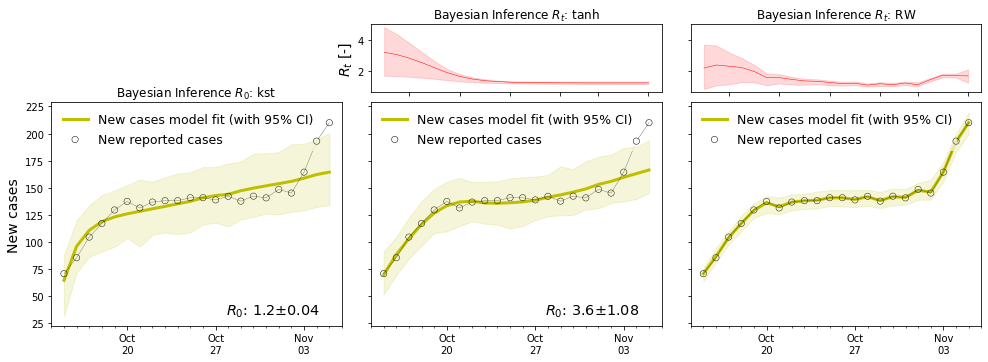

In [14]:
#%% Plotting

def Plot_newCases(traceComp,ax1,NewCases_smooth):
    Median = (np.median(traceComp, axis=0)) 
    lower =  (np.percentile(traceComp, q=2.5, axis=0))
    upper = (np.percentile(traceComp, q=97.5, axis=0))

    
    ax1.plot(time_fit, Median,color = 'y',lw=3,zorder=1, label=r'New cases model fit (with 95% CI)') # plotting t, b separately 
    ax1.plot(time_fit, NewCases_smooth[:-window], color = 'black',lw=0.5,zorder=3, alpha=0.5) # 
    ax1.scatter(time_fit, NewCases_smooth[:-window],s=40,lw=0.5, zorder=10, facecolors='none', edgecolors='k', label='New reported cases')
    ax1.fill_between(time_fit, lower, upper, zorder=10, alpha=0.15, color='y')
    
    
    
    leg = plt.legend(loc='upper left',ncol=1,frameon=True,fontsize=12.5)
    leg.get_frame().set_linewidth(0.0)
    
    
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax1.xaxis.set_minor_locator(mdates.DayLocator())
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%d'))
    
    
    ax1.set_xlim([Start_time-pd.Timedelta(days=1), Start_time + pd.Timedelta(pd.offsets.Day(Tmax_plot))]) 
    ax1.xaxis.set_tick_params(labelsize=10)
    ax1.yaxis.set_tick_params(labelsize=10)
    
    
    
def PlotRt(TraceComp,time,ax,appr):

    median = (np.median(TraceComp, axis=0)) 
    lower = (np.percentile(TraceComp, q=2.5, axis=0))
    upper = (np.percentile(TraceComp, q=97.5, axis=0))

    ax.plot(time, median, color = 'r',lw=0.5,zorder=3, alpha=1.0) # 
    ax.fill_between(time, lower, upper, zorder=1, alpha=0.15, color='r')
    ax.set_xticklabels('')
    ax.set_title(r'Bayesian Inference $R_{t}$: '+appr) 



#%%

fig = plt.figure(figsize=(1200/72,400/72))
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.15)




appr = 'kst'
ax1 = plt.subplot(gs[1:, 0])
Plot_newCases(ppc['obs_'+appr],ax1,NewCases_smooth)

R0_kst_mean = np.mean(trace['R0_'+appr])
R0_kst_std = np.std(trace['R0_'+appr])
ax1.text(0.6,0.05,r'$R_{0}$: '+f"{R0_kst_mean:.1f}"+r'$\pm$'+f'{R0_kst_std:.2f}',transform=ax1.transAxes,fontsize='x-large', horizontalalignment='left')
ax1.set_title(r'Bayesian Inference $R_{0}$: '+appr) 
plt.ylabel('New cases',fontsize=14)




appr = 'tanh'
axRt_1 = plt.subplot(gs[0, 1])
PlotRt(trace['Reff_'+appr],time_fit,axRt_1,appr)
plt.ylabel(r'$R_{t}$ [-]',fontsize=14)


ax2 = plt.subplot(gs[1:, 1], sharey=ax1)
Plot_newCases(ppc['obs_'+appr],ax2,NewCases_smooth)

R0_kst_mean = np.mean(trace['R0_'+appr])
R0_kst_std = np.std(trace['R0_'+appr])
ax2.text(0.6,0.05,r'$R_{0}$: '+f"{R0_kst_mean:.1f}"+r'$\pm$'+f'{R0_kst_std:.2f}',transform=ax2.transAxes,fontsize='x-large', horizontalalignment='left')
plt.setp(ax2.get_yticklabels(), visible=False)    




appr = 'RW'
axRt_2 = plt.subplot(gs[0, 2], sharey=axRt_1)
plt.setp(axRt_2.get_yticklabels(), visible=False)

PlotRt(trace['Reff_'+appr],time_fit,axRt_2,appr)

ax3 = plt.subplot(gs[1:, 2], sharey=ax1)
Plot_newCases(ppc['obs_'+appr],ax3,NewCases_smooth)
plt.setp(ax3.get_yticklabels(), visible=False)